# **1. Perkenalan**

Nama     : Rebran Natanael Lumbanraja, Phase 2, Batch 6

# **Penjelasan Dataset**

Dataset yang digunakan pada Notebook ini dapat dilihat di [link](https://www.kaggle.com/blastchar/telco-customer-churn)

The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

## **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# import warnings
# warnings.filterwarnings("ignore")

## **DATA LOADING**

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df[df.columns[:11]].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No


In [4]:
df[df.columns[11:]].head()

,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df[df.duplicated()].shape

(0, 21)

In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
# Proporsi keberadaan label target Churn = 1 terhadap data total

df[df.Churn=='Yes'].shape[0]/len(df)*100

26.536987079369588

In [10]:
Counter(df.Churn)

Counter({'No': 5174, 'Yes': 1869})

Berdasarkan Loading data dan eksplorasi sederhana diketahui:
- Tidak terdapat data duplikat.
- Tidak terdapat missing value.
- Feature TotalCharges memiliki tipe data object dimana seharusnya berbentuk float/numeric.
- label target Churn = 1 memiliki proporsi 26.5% dari dataset total.

## **DATA CLEANING**

**Drop customerID**

In [11]:
df.drop('customerID', axis=1, inplace=True)

**Handling data pada feature TotalCharges**

In [12]:
df[df['TotalCharges']==' '].shape

(11, 20)

Terdapat data kosong berupa spasi sebanyak 11 entry data pada feature `TotalCharges`

In [13]:
# replace spasi menjadi nan
df.TotalCharges.replace(' ', np.nan, inplace=True)

In [14]:
df[df.TotalCharges.isna()].shape

(11, 20)

In [15]:
# melakukan drop missing value
df.dropna(inplace=True)

In [16]:
# merubah feature TotalCharges menjadi bentuk numerik
df.TotalCharges = pd.to_numeric(df.TotalCharges)

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


In [18]:
cat = [i for i in df.columns if i not in df.describe().columns]

for i, col in enumerate(cat):
    print('{}. {}\n' .format(i+1, col))
    print(df[col].value_counts())
    print('-'*50)

1. gender

Male      3549
Female    3483
Name: gender, dtype: int64
--------------------------------------------------
2. Partner

No     3639
Yes    3393
Name: Partner, dtype: int64
--------------------------------------------------
3. Dependents

No     4933
Yes    2099
Name: Dependents, dtype: int64
--------------------------------------------------
4. PhoneService

Yes    6352
No      680
Name: PhoneService, dtype: int64
--------------------------------------------------
5. MultipleLines

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64
--------------------------------------------------
6. InternetService

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64
--------------------------------------------------
7. OnlineSecurity

No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64
-------------------------------------

Berdasarkan penjabaran diatas, didapatkan:
- Label `No` pada `InternetService` memiliki jumlah entry data (1520) sama dengan label `No internet service` pada feature: `OnlineSecurity `, `OnlineBackup`, `DeviceProtection`, `TechSupport `, `StreamingTV`, dan `StreamingMovies`.
- Label `No` pada `PhoneService` memiliiki jumlah entry data (680) yang sama dengan label `No phone service` pada feature `MultipleLines`.

Akan dilakukan pengecekan lebih lanjut apakah kesamaan label tersebut identik atau tidak.

In [19]:
df[(df.InternetService=='No')|
    (df.OnlineSecurity=='No internet service')|
    (df.OnlineBackup=='No internet service')|
    (df.DeviceProtection=='No internet service')|
    (df.TechSupport=='No internet service')|
    (df.StreamingTV=='No internet service')|
    (df.StreamingMovies=='No internet service')].shape

(1520, 20)

Berdasarkan pengujian diatas, shape yang memenuhi semua kondisi tersebut ialah 1520 atau sama dengan jumlah label `No internet service` pada setiap label. Maka dapat disimpulkan keberadaan label tersebut pada setiap feature mengacu pada hal yang sama.

In [20]:
df[(df.PhoneService=='No')|(df.MultipleLines=='No phone service')].shape

(680, 20)

Hal yang sama juga berlaku pada label `No phone service`.

**Encoding**

Proses encoding yang dilakukan meliputi:
- Binary Encoding: gender, Partner, Dependents, PhoneService, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PaperlessBilling, PaymentMethod (Automatic), Churn.
- Label Encoding: Internet Service, Contract.

In [21]:
# Binary Encoding

# replace label gender and Yes or No
bin_col = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
'StreamingMovies', 'PaperlessBilling', 'Churn']

label_gender = {'Female': 0, 'Male': 1}
label_bin = {'No': 0, 'Yes': 1}

for i in bin_col:
    if i == 'gender':
        df[i].replace(label_gender, inplace=True)
    else:
        df[i].replace(label_bin, inplace=True)

# replace label no phone service
df.MultipleLines.replace('No phone service', 0, inplace=True)

# replace label No internet service
no_inet_serv = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

for i in no_inet_serv:
    df[i].replace('No internet service', 0, inplace=True)

# replace PaymentMethod
label_payment = {'Electronic check': 0, 'Mailed check': 0,
                'Bank transfer (automatic)': 1, 'Credit card (automatic)': 1}

df['Payment_auto'] = df.PaymentMethod.replace(label_payment)

In [22]:
# Label Encoding

# label encoding pada feature InternetService
inet_serv = {'No': 0, 'DSL': 1, 'Fiber optic': 2}
df.InternetService.replace(inet_serv, inplace=True)

# label encoding pada feature Contract
label_contract = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df.Contract.replace(label_contract, inplace=True)

In [23]:
# Make new columns for Internet Access
df['Internet_access'] = [0 if i == 0 else 1 for i in df.InternetService]
df['Internet_DSL'] = [1 if i == 1 else 0 for i in df.InternetService]
df['Internet_Fiber'] = [1 if i == 2 else 0 for i in df.InternetService]

Dataset akan dipisahkan menjadi data:

- train: digunakan dalam proses eksplorasi dan acuan dalam pembuatan model.
- val: digunakan dalam proses evaluasi model.
- test digunakan dalam pengujian inference.

In [24]:
X = df.drop('Churn', axis=1).copy()
y = df.Churn.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0, stratify=y_train)

In [25]:
def print_shape(features, target, tipe):
    print('Jumlah entry data pada X_%s:'%tipe, features.shape)
    print('Jumlah entry data pada y_%s:'%tipe, target.shape)
    print('-'*50)

print_shape(X_train, y_train, 'train')
print_shape(X_val, y_val, 'val')
print_shape(X_test, y_test, 'test')

Jumlah entry data pada X_train: (4218, 23)
Jumlah entry data pada y_train: (4218,)
--------------------------------------------------
Jumlah entry data pada X_val: (1407, 23)
Jumlah entry data pada y_val: (1407,)
--------------------------------------------------
Jumlah entry data pada X_test: (1407, 23)
Jumlah entry data pada y_test: (1407,)
--------------------------------------------------


## **DATA EXPLORATION**

In [26]:
df_exp = pd.concat([y_train, X_train], axis=1)
df_exp.Churn.replace({0:'Stay', 1:'Churn'}, inplace=True)
df_exp.shape

(4218, 24)

In [27]:
num = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']
cat = [i for i in df_exp.columns if i not in num]
cat.append('Churn')

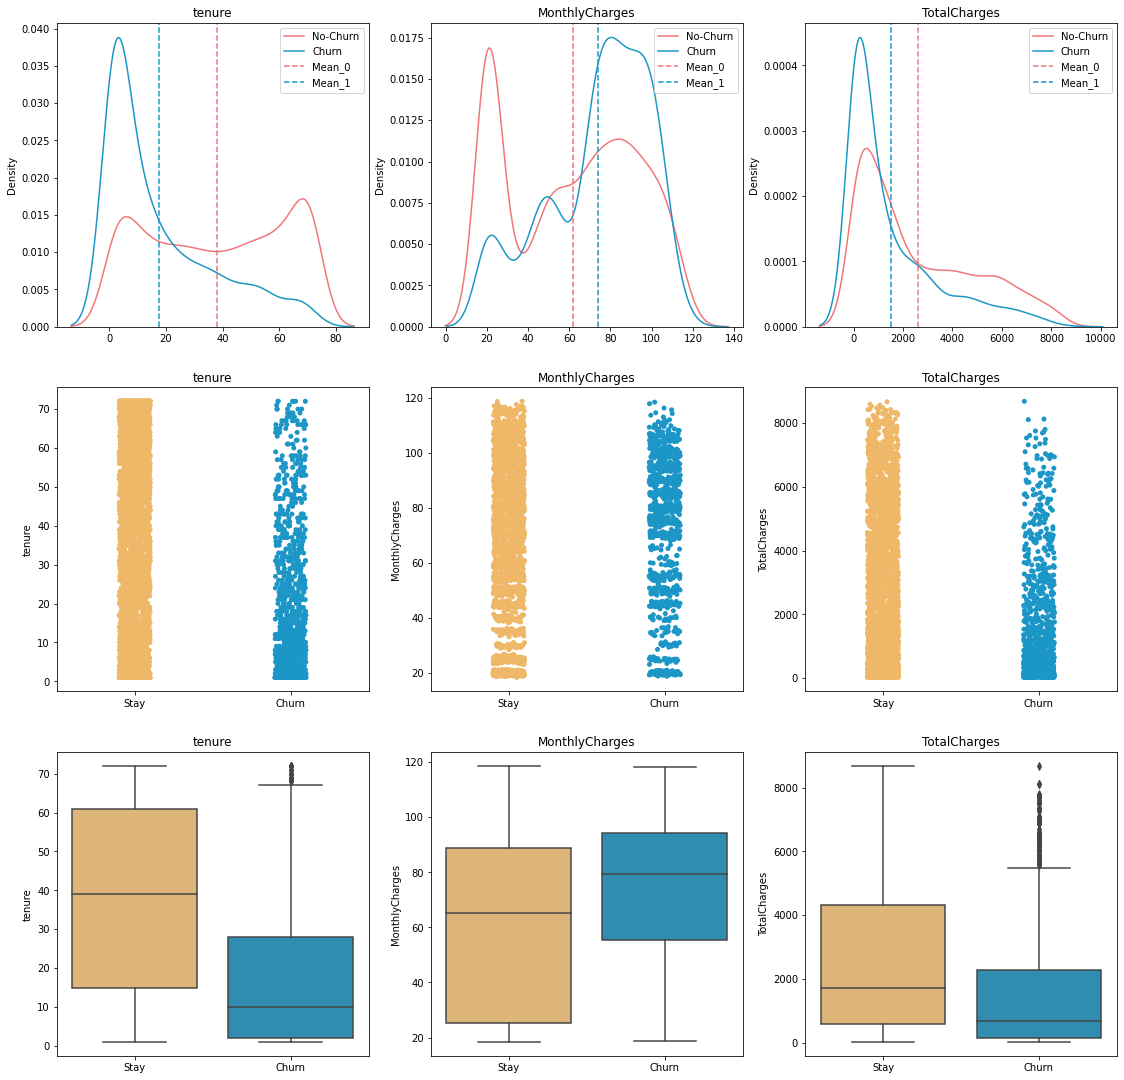

In [28]:
plt.figure(figsize=[19,19])

for i, column in enumerate(df_exp[num].columns[1:]):
    i += 1
    ax = plt.subplot(3, 3, i)

    sns.kdeplot(ax=ax,data=df_exp[df_exp.Churn=='Stay'][num], x=column, color='#EF767A', label='No-Churn')
    sns.kdeplot(ax=ax,data=df_exp[df_exp.Churn=='Churn'][num], x=column, color='#1B96C6', label='Churn')

    ax.axvline(df_exp[df_exp.Churn=='Stay'][column].mean(), color='#EF767A', linestyle='--', label="Mean_0")
    ax.axvline(df_exp[df_exp.Churn=='Churn'][column].mean(), color='#1B96C6', linestyle='--', label="Mean_1")
    ax.legend()
    
    ax.set(xlabel='')

    plt.title(column)

for i, column in enumerate(df_exp[num].columns[1:]):
    i += 1
    ax = plt.subplot(3, 3, 3+i)

    sns.stripplot(data=df_exp, y=column, x='Churn', palette=['#EEB868', '#1B96C6'])

    ax.set(xlabel='')

    plt.title(column)

for i, column in enumerate(df_exp[num].columns[1:]):
    i += 1
    ax = plt.subplot(3, 3, 6+i)

    sns.boxplot(data=df_exp, y=column, x='Churn', palette=['#EEB868', '#1B96C6'])

    ax.set(xlabel='')

    plt.title(column)

Berdasarkan visualisasi menggunakan kdeplot, stripplot, dan boxplot pada data numerik, didapatkan:
- Pada feature tenure, label Churn memiliki pusat distribusi lebih rendah dan lebih terpusat pada rentang 0 - 20, sementara persebaran data non-Churn relatif lebih merata.
- Pada feature MonthlyCharges, label Churn memiliki puncak densitas lebih tinggi pada rentang 80-100, sementara data non-Churn memiliki puncak tertinggi di sekitar 20.
- Pada feature TotalCharges, label Churn memiliki persebaran yang lebih berpusat di sekitar 1000. Hal ini sedikit bertentangan mengingat pada MonthlyCharges label Churn memiliki jumlah tagihan lebih tinggi dibandingkan non-Churn.

Selanjutnya akan dilakukan pembuangan nilai ekstrem pada lebel Churn untuk feature tenure dan TotalCharges.

**drop nilai ekstrem pada fitur tenure label Churn**

In [29]:
df_exp[(df_exp.Churn=='Churn')&(df_exp.tenure>=65)].shape[0]/df_exp[df_exp.Churn=='Churn'].shape[0]*100

3.6574487065120427

In [30]:
drop_1 = df_exp[(df_exp.Churn=='Churn')&(df_exp.tenure>=65)].index.to_list()

# drop berdasarkan indeks eksplisit
df_exp.drop(drop_1, axis=0, inplace=True)

In [31]:
# Memastikan nilai ekstrem sudah terbuang
df_exp[(df_exp.Churn=='Churn')&(df_exp.tenure>=65)].shape

(0, 24)

**drop nilai ekstrem pada fitur TotalCharges label Churn**

In [32]:
df_exp[(df_exp.Churn=='Churn')&(df_exp.TotalCharges>=6000)].shape[0]/df_exp[df_exp.Churn=='Churn'].shape[0]*100

1.6666666666666667

In [33]:
drop_1 = df_exp[(df_exp.Churn=='Churn')&(df_exp.TotalCharges>=6000)].index.to_list()

# drop berdasarkan indeks eksplisit
df_exp.drop(drop_1, axis=0, inplace=True)

In [34]:
# Memastikan nilai ekstrem sudah terbuang
df_exp[(df_exp.Churn=='Churn')&(df_exp.TotalCharges>=6000)].shape

(0, 24)

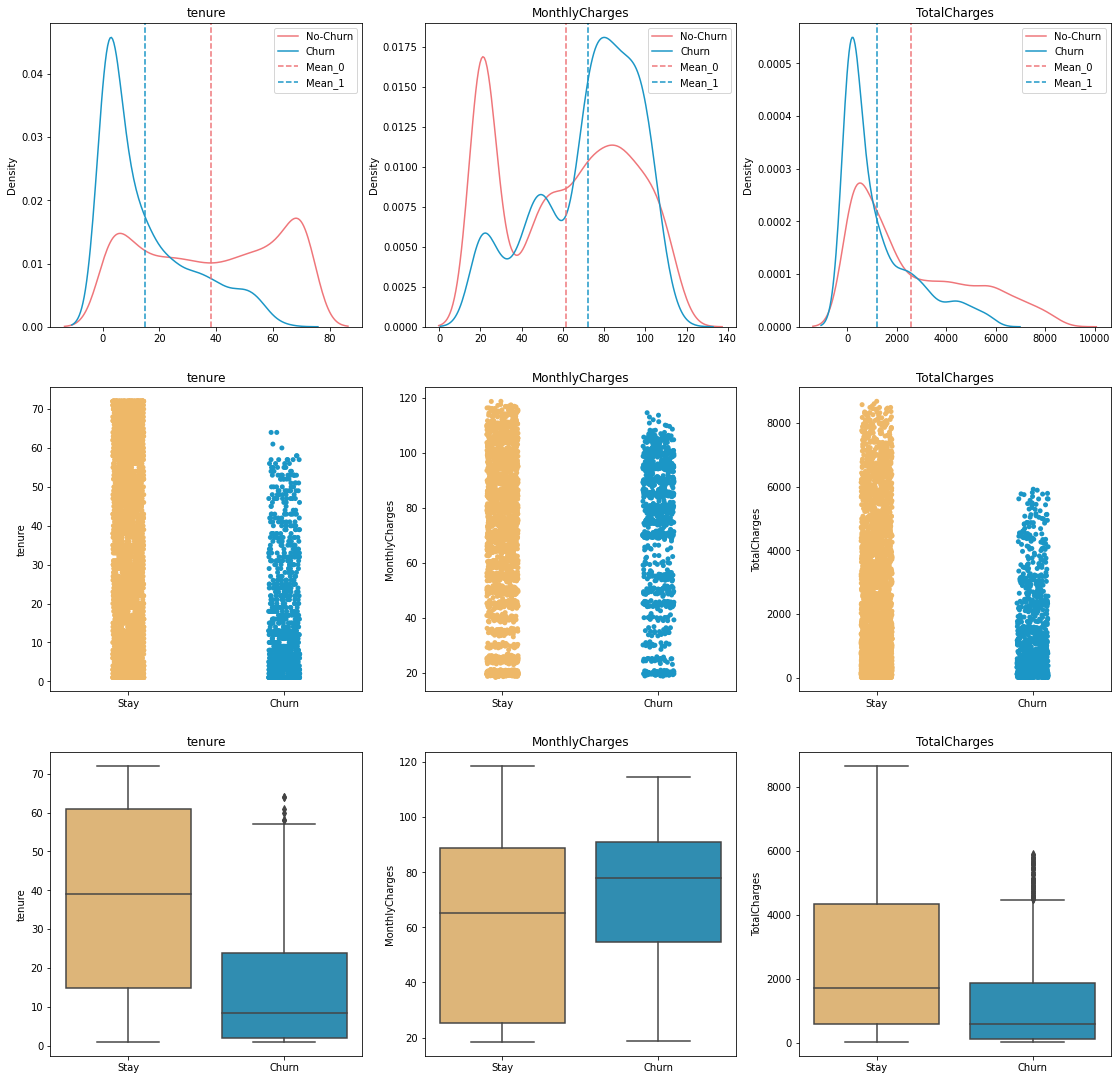

In [35]:
plt.figure(figsize=[19,19])

for i, column in enumerate(df_exp[num].columns[1:]):
    i += 1
    ax = plt.subplot(3, 3, i)

    sns.kdeplot(ax=ax,data=df_exp[df_exp.Churn=='Stay'][num], x=column, color='#EF767A', label='No-Churn')
    sns.kdeplot(ax=ax,data=df_exp[df_exp.Churn=='Churn'][num], x=column, color='#1B96C6', label='Churn')

    ax.axvline(df_exp[df_exp.Churn=='Stay'][column].mean(), color='#EF767A', linestyle='--', label="Mean_0")
    ax.axvline(df_exp[df_exp.Churn=='Churn'][column].mean(), color='#1B96C6', linestyle='--', label="Mean_1")
    ax.legend()
    
    ax.set(xlabel='')

    plt.title(column)

for i, column in enumerate(df_exp[num].columns[1:]):
    i += 1
    ax = plt.subplot(3, 3, 3+i)

    sns.stripplot(data=df_exp, y=column, x='Churn', palette=['#EEB868', '#1B96C6'])

    ax.set(xlabel='')

    plt.title(column)

for i, column in enumerate(df_exp[num].columns[1:]):
    i += 1
    ax = plt.subplot(3, 3, 6+i)

    sns.boxplot(data=df_exp, y=column, x='Churn', palette=['#EEB868', '#1B96C6'])

    ax.set(xlabel='')

    plt.title(column)

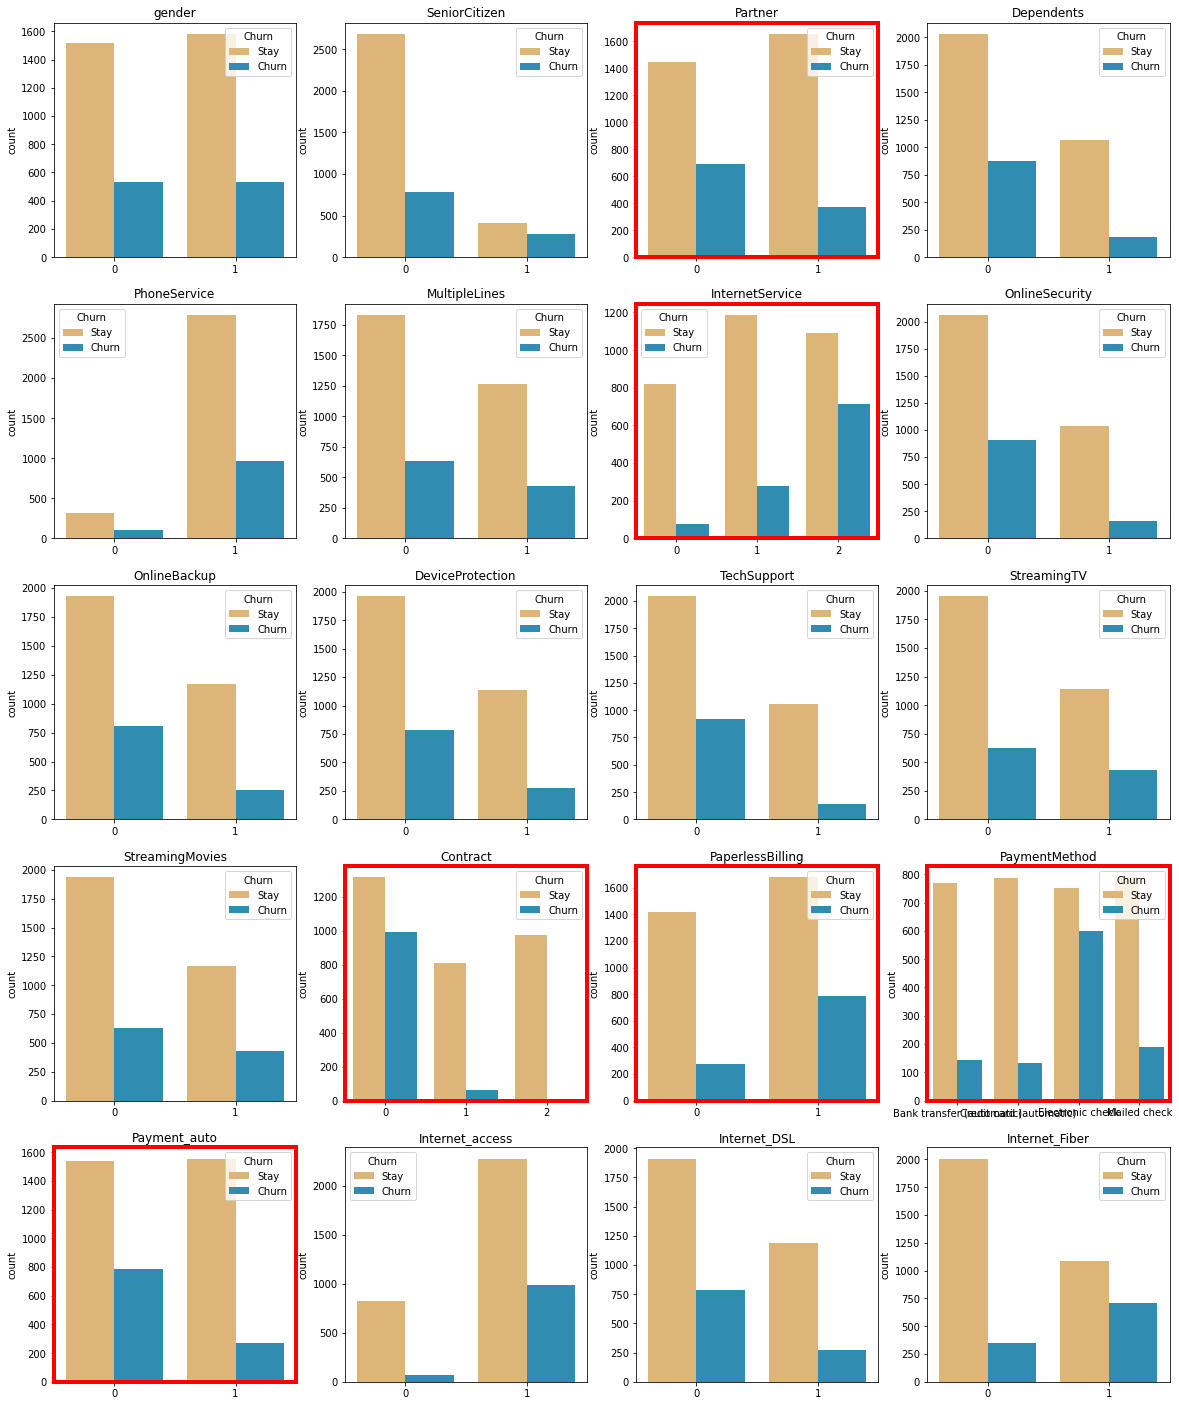

In [36]:
plt.figure(figsize=[20,25])

for i, column in enumerate(df_exp[cat].columns[:-1]):
    i += 1
    ax = plt.subplot(5, 4, i)

    if column in ['Partner', 'InternetService', 'PaperlessBilling', 'Contract', 'PaymentMethod', 'Payment_auto']:
        sns.countplot(data=df_exp, x=column, hue='Churn', palette=['#EEB868', '#1B96C6'])
        ax.spines[['bottom','top','left','right']].set_color('red')
        ax.spines[['bottom','top','left','right']].set_linewidth(4)

        ax.set(xlabel='')
        plt.title(column)
    else:
        sns.countplot(data=df_exp, x=column, hue='Churn', palette=['#EEB868', '#1B96C6'])

        ax.set(xlabel='')
        plt.title(column)

Pada visualisasi histogram perfeature yang telah dilakukan diatas telah di highlight feature yang memiliki nilai churn yang tinggi tanpa diimbangi pertambahan label Stay pada salah satu kategori, menggunakan frame berwarna merah. Yaitu:
- Partner, Label Churn lebih tinggi pada customer yang tidak memiliki partner.
- Internet Service/Internet_Fiber, Label Churn cenderung lebih tinggi pada customer dengan internet bertipekan Fiber Optic. Apakah hal ini mnegindikasikan produk tidak dapat bersaing di ranah Fiber Optic?
- Contract, Label Churn relatif sangat tinggi pada kontrak berjenis Month-to-Month. Apakah hal ini dapat diatasi dengan mengeluarkan paket bundling dengan syarat kontrak jangka panjang?
- PaperlessBilling, Perbandingan kenaikan label churn pada kategori pembayaran elektronik tidak dibarengi kenaikan yang cukup sejalan dengan label Stay. Fenomena ini juga terbilang susah untuk dijelaskan.
- Payment_method/Payment_auto, Label Churn lebih banyak terdapat pada kategori pembayaran non-otomatis. Lebih rinci, label Churn paling tinggi terdapat pada pembayaran electronic-check.

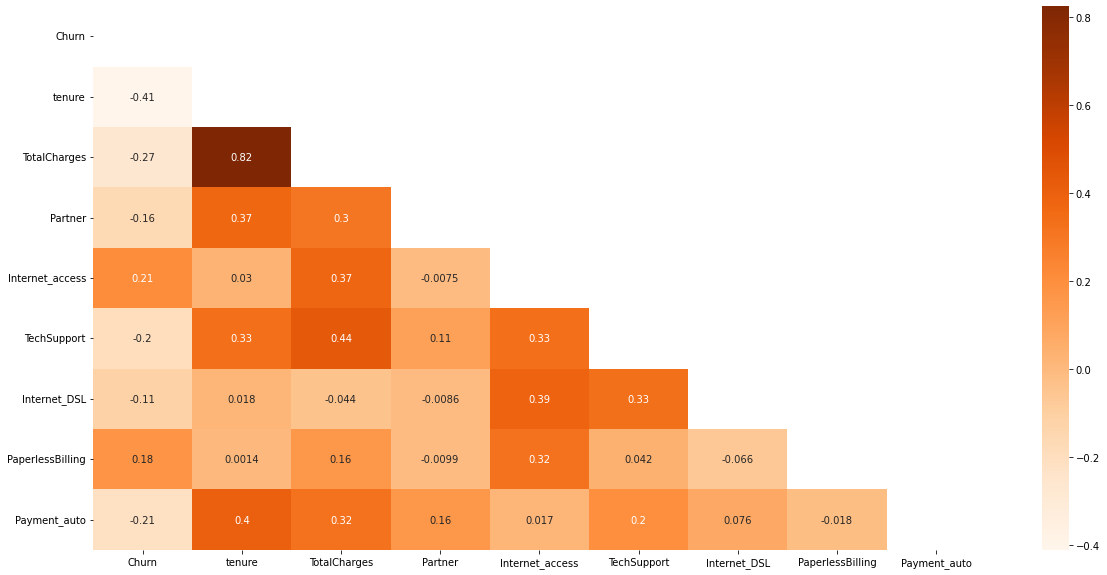

In [66]:
# Melihat korelasi pada data
df_exp.Churn.replace({'Stay':0, 'Churn':1}, inplace=True)

fig,ax = plt.subplots(figsize=[20,10])
corr = df_exp.corr()

mask = np.triu(np.ones_like(corr))

ax = sns.heatmap(corr, cmap="Oranges", mask=mask,annot=True)
plt.show()

Berdasarkan uji korelasi dan visualisasi heatmap didapatkan feature dengan korelasi diatas 0.1 dan dibawah -0.1 terhadap target `Churn` ialah: SeniorCitizen, Partner, Dependents, tenure, InternetService, OnlineSecurity, OnlineBackup, TechSupport, Contract, PapperlessBilling, MonthlyCharges, TotalCharges, Payment_auto, Internet_access, Internet_DSL, dan Internet_Fiber.

Untuk menghindari multikoloniaritas terhadap sesama feature, akan dilakukan seleksi dengan menetapkan variabel yang memiliki korelai antar feature diatas/dibawah 0.5/-0.5 tidak akan diikutkan dalam pembuatan model. Pemilihan ini juga mempertimbangkan hasil eda yang telah didapatkan dari visualisasi sebelumnya, maka diputuskan feature yang digunakan ialah: tenure, TotalCharges, Partner, Internet_access, TechSupport, Internet_DSL, PaperlessBilling, Payment_auto.

Berikut merupakan visualisasi heatmap dari uji korelasi feature terpilih.

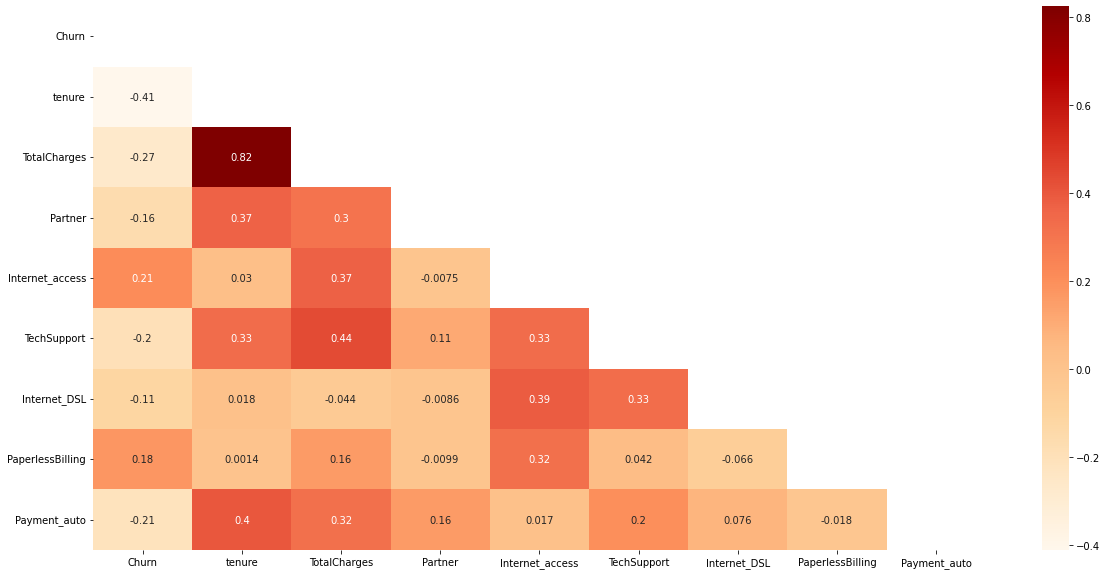

In [67]:
selected = ['Churn', 'tenure', 'TotalCharges', 'Partner', 'Internet_access',
            'TechSupport', 'Internet_DSL', 'PaperlessBilling', 'Payment_auto']

fig,ax = plt.subplots(figsize=[20,10])
corr = df_exp[selected].corr()

mask = np.triu(np.ones_like(corr))

ax = sns.heatmap(corr, cmap="OrRd", mask=mask,annot=True)
plt.show()

In [39]:
df_exp = df_exp[selected].copy()

In [40]:
# the independent variables set
X = df_exp[df_exp.columns[1:]]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

            feature       VIF
0            tenure  9.564363
1      TotalCharges  9.634602
2           Partner  2.181998
3   Internet_access  6.076215
4       TechSupport  2.073716
5      Internet_DSL  2.570503
6  PaperlessBilling  2.738185
7      Payment_auto  2.114902


Berdasarkan uji VIF, didapatkan nilai tertinggi sebesar 9.5-9.6 pada feature tenure dan TotalCharges. Meskipun begitu, pada Notebook kali ini feature tersebut diputuskan tetap akan digunakan dalam pemodelan mengingat variabel tersebut adalah 2 dari 3 variabel kontinu yang terdapat pada dataset ini.

## **DATA PREPROCESSING**

In [41]:
X_train = df_exp.drop('Churn', axis=1).copy()
y_train = df_exp.Churn.copy()

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (4159, 8)
y_train shape:  (4159,)


In [42]:
selected = X_train.columns.to_list()

X_val = X_val[selected].copy()
X_test = X_test[selected].copy()

**Undersampling dan Oversampling dengan TomekLinks() dan SMOTENC()**

DIlakukan handling imbalance dataset dengan melakukan undersampling dan oversampling pada data train. Objektif pada perlakuan ini bukan untuk menyamakan jumlah data pada kedua label target, melainkan sebatas mengurangi ketidakseimbangan pada kedua label target saja.

In [43]:
y_train[y_train==1].shape[0]/len(y_train)*100

25.534984371243084

In [44]:
Counter(y_train)

Counter({0: 3097, 1: 1062})

In [45]:
# Undersampling
tl = TomekLinks()
X_train, y_train = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))
print('Proporsi label Churn terhadap total: ', y_train[y_train==1].shape[0]/len(y_train)*100)

Resampled dataset shape Counter({0: 2799, 1: 1062})
Proporsi label Churn terhadap total:  27.505827505827508


In [46]:
# Oversampling
smotenc = SMOTENC(random_state=0, categorical_features=[2,3,4,5,6,7], sampling_strategy=0.6)
X_train, y_train = smotenc.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))
print('Proporsi label Churn terhadap total: ', y_train[y_train==1].shape[0]/len(y_train)*100)

Resampled dataset shape Counter({0: 2799, 1: 1679})
Proporsi label Churn terhadap total:  37.49441715051362


Setelah dilakukan resampling pada data train, didapatkan hasil akhir:
- label 0: 2799 entry data
- label 1: 1679 entry data
- Perubahan proporsi data label 1 sebelum dan sesudah resampling terhadap data total ialah: 25.53% menjadi 37.49%

In [47]:
print_shape(X_train, y_train, 'train')
print_shape(X_val, y_val, 'val')
print_shape(X_test, y_test, 'test')

Jumlah entry data pada X_train: (4478, 8)
Jumlah entry data pada y_train: (4478,)
--------------------------------------------------
Jumlah entry data pada X_val: (1407, 8)
Jumlah entry data pada y_val: (1407,)
--------------------------------------------------
Jumlah entry data pada X_test: (1407, 8)
Jumlah entry data pada y_test: (1407,)
--------------------------------------------------


**Scaling menggunakan MinMaxScaler()**

In [48]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

**Pipeline Input**

In [49]:
keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

In [50]:
batch_size = 64

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.shuffle(len(X_train)).batch(batch_size, drop_remainder=True)
train = train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.batch(batch_size)

test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test = test.batch(batch_size)

## **MODEL BUILDING, TRAINING, AND EVALUATION**

Pada tahap ini akan dilakukan proses pengujian pemodelan menggunakan 2 metode: Sequential dan Functional.

Akhir dari proses ini ialah memilih model terbaik yang akan digunakan dalam proses data inference.

**Define Function**

In [51]:
# Define Model's Architecture

def sequential_model():
  model = Sequential()
  model.add(Dense(32, input_dim=8, kernel_initializer= tf.keras.initializers.GlorotNormal(), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(16, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(8, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(8, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(1, activation='sigmoid'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-06)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model

In [52]:
# Define Model's Architecture

def functional_model():
  layer = tf.keras.layers
  inp = tf.keras.Input(shape=(8,))
  x = layer.Dense(32, activation="relu", kernel_initializer= tf.keras.initializers.GlorotNormal())(inp)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  x = layer.Dense(16, activation="relu")(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  x = layer.Dense(8, activation="relu")(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  x = layer.Dense(8, activation="relu")(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  concat = keras.layers.concatenate([inp, x])
  output = keras.layers.Dense(1, activation="sigmoid")(concat)
  model = keras.models.Model(inputs=[inp], outputs=[output])

  opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-06)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=["accuracy"])

  return model

In [53]:
def model_train_callback(model, epoch):
    checkpoint = keras.callbacks.ModelCheckpoint("my_model_cp.h5",
                                                save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

    history = model.fit(train, validation_data=val, epochs=epoch,
                        callbacks=[checkpoint, early_stopping])
    
    return history

In [54]:
## Evaluate on a dataset.
def eval(model, hist, data_eval):
    print('Models Performance')
    pd.DataFrame(hist.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    print('-'*50)
    print("Evaluate on test data")
    result = model.evaluate(data_eval)
    print('Test - Loss     : ', result[0])
    print('Test - Accuracy : ', result[1])
    print('-'*50)
    # make confussion matrix and classification report
    y_prob = model.predict(data_eval) 
    y_classes = [1 if i >= 0.5 else 0 for i in y_prob]
    true_categories = tf.concat([y for x, y in data_eval], axis=0)
    print('Confussion Matrix:')
    print(confusion_matrix(true_categories, y_classes))
    print('-'*50)
    print('Classification Report: \n', classification_report(true_categories, y_classes))
    print('-'*50)
    print('ROC AUC Score: ', roc_auc_score(true_categories, y_classes))

**Sequential Model**

In [55]:
# Model Building
seq_model = sequential_model()

# Model Training
hist_seq = model_train_callback(model=seq_model, epoch=200)

Epoch 1/200
69/69 [==============================] - 2s 8ms/step - loss: 0.9639 - accuracy: 0.5084 - val_loss: 0.6478 - val_accuracy: 0.6773
Epoch 2/200
69/69 [==============================] - 0s 4ms/step - loss: 0.8178 - accuracy: 0.5419 - val_loss: 0.6249 - val_accuracy: 0.7342
Epoch 3/200
69/69 [==============================] - 0s 4ms/step - loss: 0.7443 - accuracy: 0.5876 - val_loss: 0.5993 - val_accuracy: 0.7342
Epoch 4/200
69/69 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.6003 - val_loss: 0.5810 - val_accuracy: 0.7633
Epoch 5/200
69/69 [==============================] - 0s 5ms/step - loss: 0.6607 - accuracy: 0.6223 - val_loss: 0.5631 - val_accuracy: 0.7846
Epoch 6/200
69/69 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6270 - val_loss: 0.5495 - val_accuracy: 0.7839
Epoch 7/200
69/69 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6447 - val_loss: 0.5407 - val_accuracy: 0.7839
Epoch 8/200
6

Models Performance


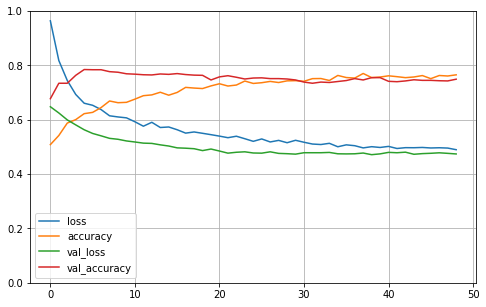

--------------------------------------------------
Evaluate on test data
22/22 [==============================] - 0s 1ms/step - loss: 0.4714 - accuracy: 0.7548
Test - Loss     :  0.4713919460773468
Test - Accuracy :  0.7547974586486816
--------------------------------------------------
Confussion Matrix:
[[784 249]
 [ 96 278]]
--------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.76      0.82      1033
           1       0.53      0.74      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.75      0.77      1407

--------------------------------------------------
ROC AUC Score:  0.7511350047367358


In [56]:
# Model Evaluation
eval(hist=hist_seq, model=seq_model, data_eval=val)

Hasil pembuatan model sequential mendapatkan hasil:
- kurva loss antara train dan val memiliki perbedaan yang kecil, dengan nilai pada epoch 49 sebesar; train_loss: 0.48 - val_loss: 0.47
- Akurasi model didapatkan 0.75 dengan recall pada label Churn sebesar 0.74.
- Skor ROC AUC yang didapatkan sebesar 0.75.

**Functional Model**

In [57]:
# Model Building
func_model = functional_model()

# Model Training
hist_func = model_train_callback(model=func_model, epoch=200)

Epoch 1/200
69/69 [==============================] - 2s 7ms/step - loss: 0.8477 - accuracy: 0.5322 - val_loss: 0.6269 - val_accuracy: 0.6972
Epoch 2/200
69/69 [==============================] - 0s 4ms/step - loss: 0.7148 - accuracy: 0.6037 - val_loss: 0.5754 - val_accuracy: 0.7448
Epoch 3/200
69/69 [==============================] - 0s 5ms/step - loss: 0.6626 - accuracy: 0.6257 - val_loss: 0.5513 - val_accuracy: 0.7448
Epoch 4/200
69/69 [==============================] - 0s 5ms/step - loss: 0.6203 - accuracy: 0.6599 - val_loss: 0.5375 - val_accuracy: 0.7719
Epoch 5/200
69/69 [==============================] - 0s 6ms/step - loss: 0.5889 - accuracy: 0.6864 - val_loss: 0.5241 - val_accuracy: 0.7797
Epoch 6/200
69/69 [==============================] - 0s 6ms/step - loss: 0.5825 - accuracy: 0.6920 - val_loss: 0.5160 - val_accuracy: 0.7804
Epoch 7/200
69/69 [==============================] - 0s 6ms/step - loss: 0.5626 - accuracy: 0.7176 - val_loss: 0.5060 - val_accuracy: 0.7832
Epoch 8/200
6

Models Performance


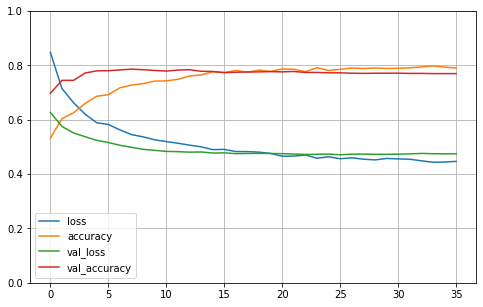

--------------------------------------------------
Evaluate on test data
22/22 [==============================] - 0s 2ms/step - loss: 0.4710 - accuracy: 0.7726
Test - Loss     :  0.47096991539001465
Test - Accuracy :  0.7725657224655151
--------------------------------------------------
Confussion Matrix:
[[835 198]
 [122 252]]
--------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1033
           1       0.56      0.67      0.61       374

    accuracy                           0.77      1407
   macro avg       0.72      0.74      0.73      1407
weighted avg       0.79      0.77      0.78      1407

--------------------------------------------------
ROC AUC Score:  0.7410610288293793


In [58]:
# Model Evaluation
eval(hist=hist_func, model=func_model, data_eval=val)

Hasil pembuatan model functional mendapatkan hasil:
- kurva loss antara train dan val memiliki perbedaan realtif besar, dengan nilai loss pada epoch ke-69 sebesar; train_loss: 0.4434 - val_loss: 0.4777
- Akurasi model didapatkan 0.77 dengan recall pada label Churn sebesar 0.68.
- Skor ROC AUC yang didapatkan sebesar 0.74.

Dalam menentukan model terpilih, beberapa hal yang dipertimbangkan ialah:
- Selisih besaran loss antara data train dan val tidak jauh.
- Besaran nilai recall pada label 1 semenjak data berasal dari data imbalance. Hal ini juga bermaksud menghindari kesalahan dimana customer diprediksi stay tetapi kenyataan churn.
- Nilai Skor ROC AUC.

Berdasarkan hal tersebut, diputuskan model terpilih merupakan model sequential.

## **CLASSIFICATION'S PROBABILITY TUNING**

Dilakukan tuning probability treshold dengan tujuan memaksimalkan nilai recall pada label Churn hingga sebesar 0.9.

Dalam prosesnya akan dilakukan pengujian looping menggunakan beberapa besaran treshold, yaitu: 0.12, 0.13, 0.14, dan 0.15.

In [59]:
for tres in [0.12, 0.13, 0.14, 0.15]:
    tres_tuning = seq_model.predict(val)

    tres_tuning = [1 if i >= tres else 0 for i in tres_tuning]
    print('Probability Treshold: ', tres)
    print('')
    print('Confussion Matrix:')
    print(confusion_matrix(y_val, tres_tuning))
    print('-'*50)
    print('Classification Report: \n', classification_report(y_val, tres_tuning))
    print('-'*50)
    print('-'*50)

Probability Treshold:  0.12

Confussion Matrix:
[[443 590]
 [ 33 341]]
--------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.43      0.59      1033
           1       0.37      0.91      0.52       374

    accuracy                           0.56      1407
   macro avg       0.65      0.67      0.55      1407
weighted avg       0.78      0.56      0.57      1407

--------------------------------------------------
--------------------------------------------------
Probability Treshold:  0.13

Confussion Matrix:
[[474 559]
 [ 37 337]]
--------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.46      0.61      1033
           1       0.38      0.90      0.53       374

    accuracy                           0.58      1407
   macro avg       0.65      0.68      0.57      1407
weigh

Besaran probability treshold yang diputuskan dipilih untuk digunakan dalam memprediksi data inference ialah sebesar 0.13 dengan recall pada label Churn sebesar 0.90.

## **MODEL SAVING**

In [60]:
# Menyimpan model yang telah dibuat
seq_model.save("model_churn.h5")

## **MODEL INFERENCE**

Proses inferensi model dilakukan menggunakan model terpilih yaitu model sequential dan dilakukan terhadap data test. Adapun probability treshold yang digunakan dalam menentukan kategori perlu disesuaikan terlebih dahulu dengan probability treshold yang telah dipilih yaitu 0.13.

In [61]:
inference = seq_model.predict(test)

inference = [1 if i >= 0.13 else 0 for i in inference]
print('Confussion Matrix:')
print(confusion_matrix(y_test, inference))
print('-'*50)
print('Classification Report: \n', classification_report(y_test, inference))
print('-'*50)
print('ROC AUC Score: \n', roc_auc_score(y_test, inference))


Confussion Matrix:
[[519 514]
 [ 32 342]]
--------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.50      0.66      1033
           1       0.40      0.91      0.56       374

    accuracy                           0.61      1407
   macro avg       0.67      0.71      0.61      1407
weighted avg       0.80      0.61      0.63      1407

--------------------------------------------------
ROC AUC Score: 
 0.7084293191006932


Berdasarkan pengujian inferensi yang telah dilakukan terhadap data test didaptakan hasil:
- Akurasi model secara keseluruhan ialah 0.61 dengan Skor ROC AUC sebesar 0.70.
- Nilai Recall pada label 1/Churn sebesar 0.91, model dapat memprediksi tepat 342 dari 374 pelanggan yang Churn.
- Nilai Precision pada label 1/Churn sebesar 0.40, model masih melakukan kesalahan mengeluarkan prediksi benar yaitu hanya 342 benar dari total 856 jumlah prediksi Churn.

## **CONCLUSION**

Pada Notebook ini telah dilakukan pemodelan untuk memprediksi Churn dari pelanggan.

Dalam proses pembuatan model dilakukan:
- Pembuangan data yang memiliki nilai ekstrem pada label Churn di feature tenure dan TotalCharges.
- Penyeleksian features dengan pertimbangan persebaran data maupun tingkat korelasi terhadap label Churn.
- Features terpilih yaitu: tenure, TotalCharges, Partner, Internet_access, TechSupport, Internet_DSL, PaperlessBilling, Payment_auto.
- Dilakukan Undersampling terhadap label 0/Stay dan Oversampling terhadap label 1/Churn.
- Scaling menggunakan MinMaxScaler.

Terhadap data validation dan data inference dilakukan:
- Penyetaraan feature terhadap data train.
- Scaling menggunakan MinMaxScaler berdasarkan data train.

Sebelum melakukan pemodelan dilakukan pembuatan input pipeline dan pemilihan model terhadap 2 metode, yaitu: Model Sequential dan Model Functional. Model Sequential diputuskan sebagai model terpilih dengan pertimbangan: Selisih loss kecil antara data train dan val serta nilai recall pada label 1/Churn lebih baik. Sebagai upaya untuk meningkatkan performa recall pada model dilakukan tuning probability treshold dan diputuskan treshold terpilih sebesar 0.13 yang menghasilkan recall terhadap label 1 sebesar 0.9.

Pengujian model terhadap data Inferense mendapatkan nilai Recall sebesar 0.9 dan Precision sebesar 0.4.

Berdasarkan hasil hasil eksplorasi data, bagi customer yang diprediksi Churn dengan tipe kontrak Month-to-Month dapat diberikan bundling promo dengan syarat Contract jangka panjang untuk menghindari terjadinya Churn. Selain itu perlu dilakukan peninjauan lebih lanjut apakah produk jasa dapat bersaing/kebijakan berpihak pada pengguna internet Fiber Optik semenjak ditemukan tingkat Churn yang tinggi pada kategori tersebut.